# ELEN4009A Software Engineering Group Project
## Hraklis Papageorgiou -2137492
## Joseph Baggott - 2169705

Kaggle is an online community of machine learning and data-scientist practitioners. It hosts competitions and challenges one to learn about data analysis and machine learning. Is this project the titanic Kaggle competition is completed. Participants must use “machine learning to create a model that predicts which passengers survived the Titanic shipwreck” – Kaggle Titanic competition (https://www.kaggle.com/competitions/titanic/overview). 

The competition provides two sets of data on the shipwreck – training and testing data. The difference between the two is that the training data contains information about whether the passengers survived, and the testing data does not. The model must then predict whether the passengers in the testing data survived and the output of this is then uploaded to Kaggle for them to score. 
### RMS Titanic
![Titanic](./pictures/titanic.webp)
On the 15th of April 1912, the RMS Titanic sunk on her maiden voyage after colliding with an iceberg. The death toll was extremely high, killing 1502 out of 2224 passengers and crew. 

There were not enough lifeboats for all the passengers and crew of the titanic. As a result, certain groups had a higher chance of surviving the catastrophe than others. Whether it be women, children, or the upper class. This project will elaborate on identifying these groups within the provided data and using this insight to create an accurate and prediction model.



### Importing Dependancies and Data. Defining Data Visualisation tool to View the Survivors For a Given Feature.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import pandas_profiling as pp
import warnings
warnings.filterwarnings('ignore')

import pylab 
import seaborn as sns

In [2]:
# Importing Data + Combing train and test data
train = pd.read_csv('train.csv') 
test = pd.read_csv('test.csv') 
test_ids = test['PassengerId']
Test_ID = test.PassengerId
# Combining Test and Train Data - this is in order to obtain a more holistic view of the data (Insert -1 For survived under test data)
test.insert(loc=1, column='Survived', value=-1)
data = pd.concat([train, test], ignore_index=True)


In [3]:
# Data visualisation Tool
def charts(feature, df):
    print('\n           ____________________________ Plots of', feature, 'per Survived and Dead: ____________________________')
    # Pie of all Data
    fig = plt.figure(figsize=(20,5))
    f1 = fig.add_subplot(131)
    cnt = df[feature].value_counts()
    g = plt.pie(cnt, labels=cnt.index, autopct='%1.1f%%', shadow=True, startangle=90)
    
    # Count Plot By Survived and Dead
    f = fig.add_subplot(132)
    g = sns.countplot(x=feature, hue='Survived', hue_order=[1,0], data=df, ax=f)

    # Percent stacked Plot
    survived = df[df['Survived']==1][feature].value_counts()
    dead = df[df['Survived']==0][feature].value_counts()
    df2 = pd.DataFrame([survived,dead])
    df2.index = ['Survived','Dead']
    df2 = df2.T
    df2 = df2.fillna(0)
    df2['Total'] = df2.Survived + df2.Dead
    df2.Survived = df2.Survived/df2.Total
    df2.Dead = df2.Dead/df2.Total
    df2.drop(['Total'], axis=1, inplace=True)
    f = fig.add_subplot(133)
    df2.plot(kind='bar', stacked=True, ax=f)
    del df2, g, f, cnt, dead, fig

In [4]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
def print_score(clf, X_train, y_train, train=True):
    '''
    print the accuracy score, classification report and confusion matrix of classifier
    '''
    if train:
        '''
        training performance
        '''
        print("Train Result:\n")
        y_train_predict=clf.predict(X_train);
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_train, y_train_predict)))
        print("Classification Report: \n {}\n".format(classification_report(y_train,y_train_predict)))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_train, y_train_predict)))

        res = cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy')
        print("Average Accuracy: \t {0:.4f}".format(np.mean(res)))
        print("Accuracy SD: \t\t {0:.4f}".format(np.std(res)))

# Analysing The Provided Data

First we will start by looking at the default features in the dataset as well as missing features. 
The Following is the description of each of the features:
* Pclass: The class that the passenger was in 1 - first, 2 - second, 3 - third. 
* Name: Simply the name of passenger - includes title.
* Sex: The gender of the passenger.
* SibSp: The number of siblings and spouses on board with that passenger.
* Parch: The number of parents or children on board with that passenger.
* Ticket: The ticket ID of that passenger.
* Fare: The price of the ticket used by that passenger.
* Cabin: The cabin that the passenger stayed in. 
* Embarked: Where that passenger embarked. 

In [5]:
data.head(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S


In [6]:
data.isna().sum()

PassengerId       0
Survived          0
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

We see that most of the data is complete except for age, fare, and cabin. We will deal with these later in the notebook. 

The parameters that immediately draw the most attention are Sex, Class, Fare and Age. This is because women and children took a preference for places on the lifeboats, and first-class also had higher survival rates. This is corroborated by the data visualisation.  



### Sex

As shown by the graphs below, women have a far more significant survival rate than men. 


           ____________________________ Plots of Sex per Survived and Dead: ____________________________


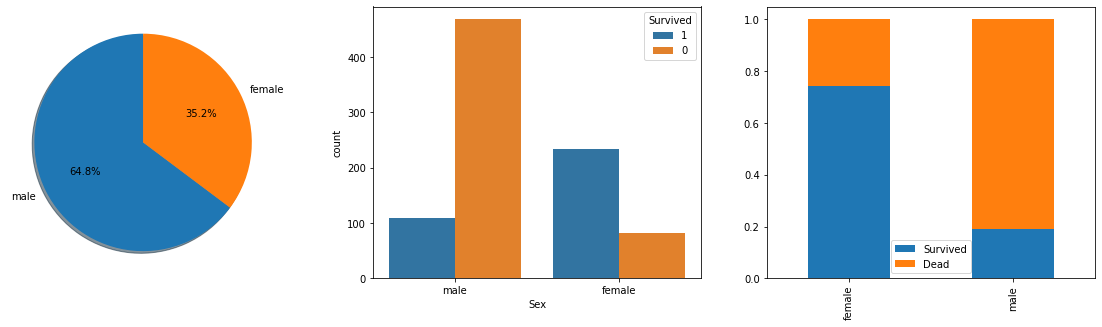

In [7]:
charts('Sex', data[data.Survived>=0])

### Class

As expected, people in higher classes had higher chances of survival. This is likely due to fact that classes were further from the deck as the class decreased and because of socioeconomic discrimination. This is again corroborated by the graphs. 


           ____________________________ Plots of Pclass per Survived and Dead: ____________________________


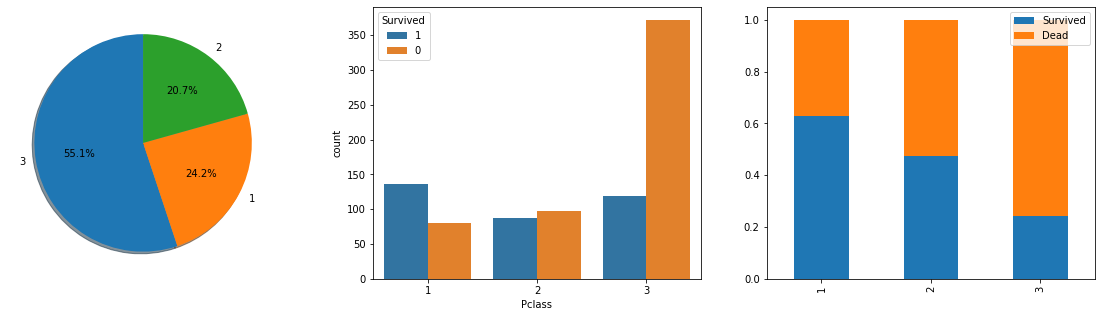

In [8]:
charts('Pclass', data[data.Survived>=0])

### Fare and Age
Fare is another indicator of socioeconomic standing, and as a result, also has a correlation with survival chances. This is shown later in the notebook.

Again, children took preference over adults and this is also shown later in the notebook.

In [9]:
# Fill empty Fare Value with mean fare - only one fare value is missing so this is adequate
mean_value = data['Fare'].mean().round(4)
data['Fare'].fillna(value = mean_value, inplace = True)


### Embarked
Interestingly there was a slight correclation with the location a passenger boarded and their survival. The single missing value is replaced by S - the highest occuring location. Again this correlation may be due to Socioeconomic reasons, whereby richer passengers came from certain areas. For instance, the crew boarded at Southampton [3].  


           ____________________________ Plots of Embarked per Survived and Dead: ____________________________


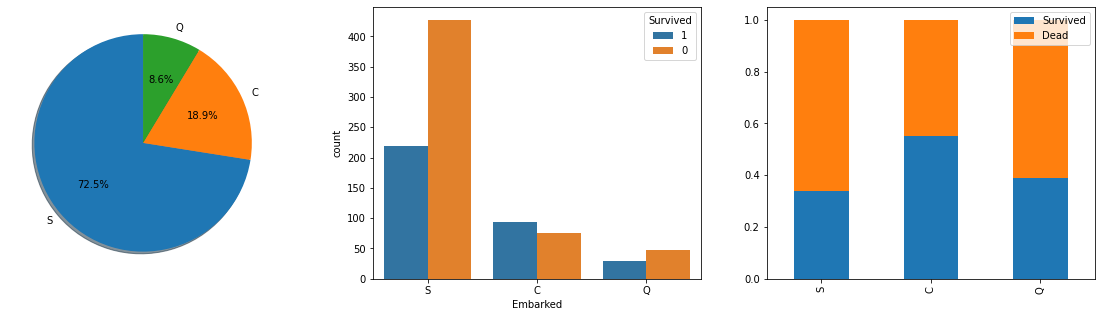

In [10]:
data.Embarked.fillna("S", inplace=True)
charts('Embarked', data[data.Survived>=0])

### Name, Ticket and Cabin
One's first instinct is to drop these features. Given that Name and Ticket is categorical data and because there are so many values missing in the Cabin. However, there is valuable information is all these categories. This is explored later in the notebook.

# Title
As mentioned above, at first it seems that there is little information in the names of the passengers. However, in each of the names, there is a title. This title is interesting, because it contains information about the age, sex, and marital status of the passenger. 


The majority of passengers have one of the following Titles:
* Mr.
* Mrs.
* Miss.
* Master

The term 'other' represents any other Title that a passenger may have, such as Sir., Dr. or Rev. to name a few.
These titles were all grouped under other because there are so few of them. For example it would not be worthwhile to have a title specifcally for Sir. as there is only one passenger with that title.

The graphs below show that there is a strong correlation between the title of the passenger and the chance of survival. 

In [11]:
# Function to find the title in 'Name'
def find_title(name):
    if 'Mr.' in name:
        return 'Mr.'
    elif 'Mrs.' in name:
        return 'Mrs.'
    elif 'Miss.' in name:
        return 'Miss.'
    elif 'Master.' in name:
        return 'Master.'
    else:
        return 'other'

In [12]:
# Add new column 'Title' and populate it with the title extracted from 'Name'
data["Title"] = None
data['Title'] = data['Name'].apply(find_title)
# Now that all the information is extracted from the name of the passenger, we can drop the name to clean the dataframe. 
data.drop('Name', axis =1, inplace = True)


           ____________________________ Plots of Title per Survived and Dead: ____________________________


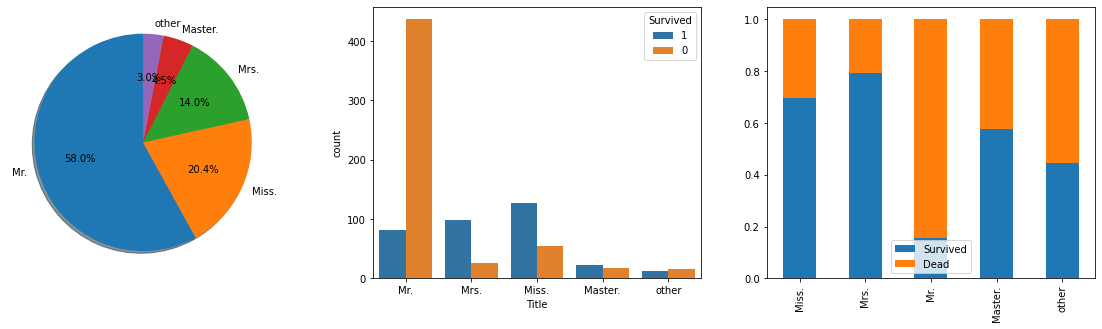

In [13]:
charts('Title', data[data.Survived>=0])

# Filling Null Values for Age

Because there is such a high number of passengers that are missing an age value. Lots of information would be lost if these values were simply replaced by the median or mean of the overall age. As a result, a more complex method has been used to calculate the age for the Null values. 


Finally, lots of information about the passengers aboard the Titanic was obtained after it struck the iceberg. This means that when the age of a person is unknown it is likely that they perished during the catastrophe - this information is captured below. 

The three major features that can indicate what the age of a passenger may be are: Title, Pclass and Parch
A pssenger's title can indicate in the following way:

Age by Title:
* Master. - Title given to a male below the age of 18. 
* Mr. - Title given to a male above the age of 18.
* Miss - Title given to an unmarried woman, woman who are not married tend to be youger, such as female children
* Mrs - Title given to a married woman, a woman needs to be of legal age in order to be married. ie at least above the age of 18

A passenger's Parch is useful as it indicates how many children or parents a passenger has and is particulary useful when used alongside Title
* Parch can further identify a Miss. because a Miss. with a non zero parch value indicates that they are onboard with their parents indicating that they are a child. A Miss. is unlikely to have children as they are not married so the parch value can be interpreted as solely having parents on board. If the parch value is zero the passenger is an adult woman yet to be married and likely above the age of 18 since they do not need to travel with their parents.
* Similarily, the parch value for a Mr. indicates if they have children on board, so a Mr. with a non-zero parch value would typically be older than a Mr. with a zero parch value.

Pclass:

A passenger's class is useful because a person tends to be older if they are in a higher income bracket. 


In [14]:
# Add New column 'isAgeNull' and Populate it with if the Age value is missing or not
data['isAgeNull'] = None
data['isAgeNull'] = (~data['Age'].isnull()).astype(int)
data.head(1)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,isAgeNull
0,1,0,3,male,22.0,1,0,A/5 21171,7.25,NaN,S,Mr.,1


In [15]:
# Find mean age by Pclass, Parch and Title and set missing values in Age to the respective mean
data['Age'] = data.groupby(['Parch','Pclass', 'Title'])['Age'].apply(lambda group: round(group.fillna(group.mean()), 1))

In [16]:
# Need to account for the 3 remaining missing values in Age, so drop 'Parch' in the mean calculation to account for 
# The Sage parents with 9 children 
# and then drop 'Title' and replace with 'Sex' for person with Ms. title
data['Age'] = data.groupby(['Pclass', 'Title'])['Age'].apply(lambda group: round(group.fillna(group.mean()), 1))
data['Age'] = data.groupby(['Parch','Pclass', 'Sex'])['Age'].apply(lambda group: round(group.fillna(group.mean()), 1))
data.isna().sum()


PassengerId       0
Survived          0
Pclass            0
Sex               0
Age               0
SibSp             0
Parch             0
Ticket            0
Fare              0
Cabin          1014
Embarked          0
Title             0
isAgeNull         0
dtype: int64

### Binning Age
In order to get more consistent results, ages have been binned. 
Binning is used to reduce noise and simplifys the relationship that a feature may provide. It is useful as it puts similar values together. Binning can allow certain trends to be better recognised in graphs or by the Machine learning model, since the data is simplified to a few catogories instead of a large continuous set. 

Binning the Age feature indicates which groups of ages were most likely to have survived. The graph below shows that passengers who are infants, survive almost 100% of the time. Young children are also more likely to survive, since children tend to be prioritised in crisis. Conversly older individuals tend to die as they are physically weaker and prioritised less. For the old and young passengers, it can be noted that the effect that outliers have on the feature are mitigated. 


           ____________________________ Plots of binned_age per Survived and Dead: ____________________________


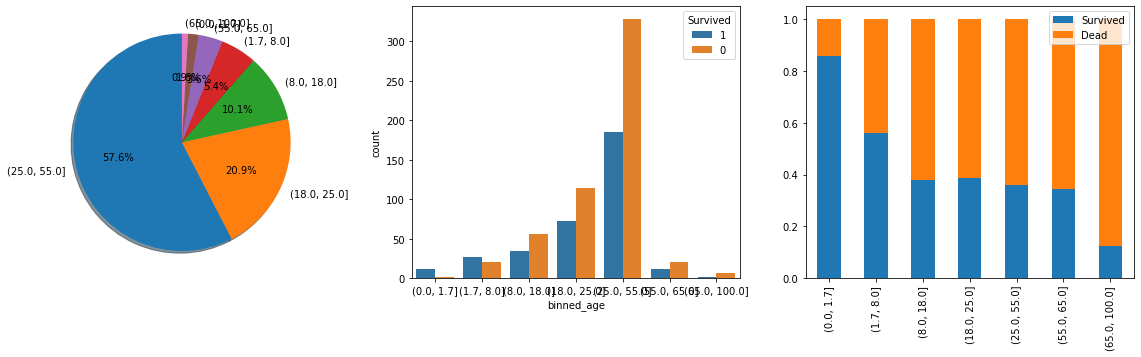

In [17]:
bins = [0, 1.7, 8, 18,25,55,65,100]
data['binned_age'] = pd.cut(data['Age'], bins)
charts('binned_age', data[(data.Survived>=0)])

# Family
![Sage Family](./pictures/sage-family.jpg)

The Sage Family: Family of 11 Who All Perished on The RMS Titanic. 

While there is some correlation between the number of siblings, parents and survival, a more robust feature would be measuring the family. The graphs below show that a passenger’s chances of survival are greater if they are traveling with a family under four members. 

From the Family chart below it can be noed that if a passenger has no realtives on board they are likely to not survive, this idea is reinforced by the hasFamily Chart below. 


           ____________________________ Plots of Family per Survived and Dead: ____________________________


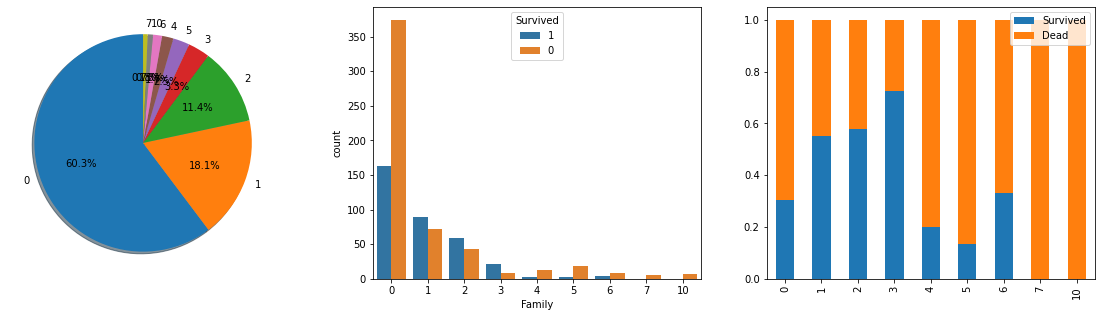

In [18]:
# Add new column 'Family' and populate it with the sum of 'Parch' and 'SibSp'
data['Family'] = None
family_col = data['Parch'] + data['SibSp']
data['Family'] = family_col
charts('Family', data[(data.Survived>=0)])

In [19]:
# Creating a Feature of Whether there is a family member of not. 
def family_zero(family):
    if family == 0:
        return 1
    else:
        return 0

data['hasFamily'] = data['Family'].apply(family_zero)


           ____________________________ Plots of hasFamily per Survived and Dead: ____________________________


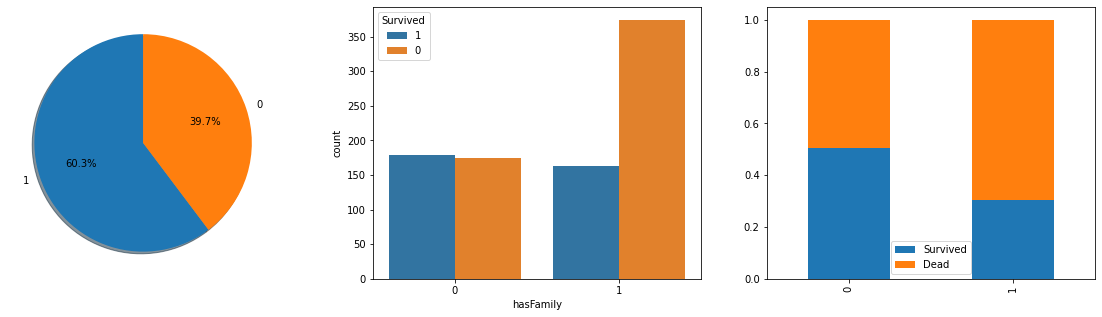

In [20]:
charts('hasFamily', data[(data.Survived>=0)])

# Ticket Data

![Ticket](./pictures/ticket.webp)

### Shared Tickets

As mentioned above, at first one would be lead to suggest that there is little information in the Ticket number of the passengers. But on further inspection, one finds that there are duplicate tickets. This means that when traveling in a group (for instance a family) one ticket would be bought for the entire group. 


           ____________________________ Plots of Shared_Ticket per Survived and Dead: ____________________________


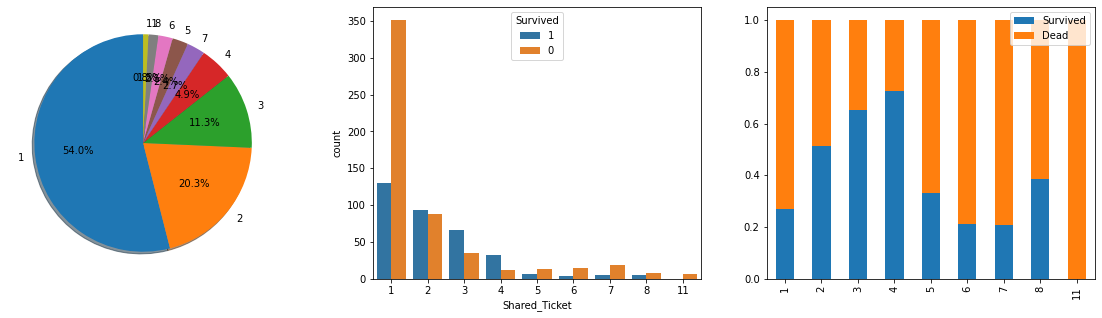

In [21]:
duplicate_ticket = data.Ticket.value_counts()
data['Shared_Ticket'] = data.Ticket.apply(lambda x: duplicate_ticket[x])
del duplicate_ticket
charts('Shared_Ticket', data[data.Survived>=0])


This graph is very similar to that of the graph produced for the family. This observation makes sense, as families would travel together in a group. However, this shared ticket category now contains extra information. The shared ticket category now contains information about whether a passenger is traveling with people that aren’t family. For instance, a friend or nanny. 

### Binning shared_tickets
As shown by the graphs above the number of people with five or more shared tickets is proportionally very low. As a result, a binning strategy has been utilized here to increase the number of passengers per category. Furthermore, due to the similarity between 3 and 4 shared tickets – these two categories have been binned together. 


           ____________________________ Plots of Shared_Ticket_Bin per Survived and Dead: ____________________________


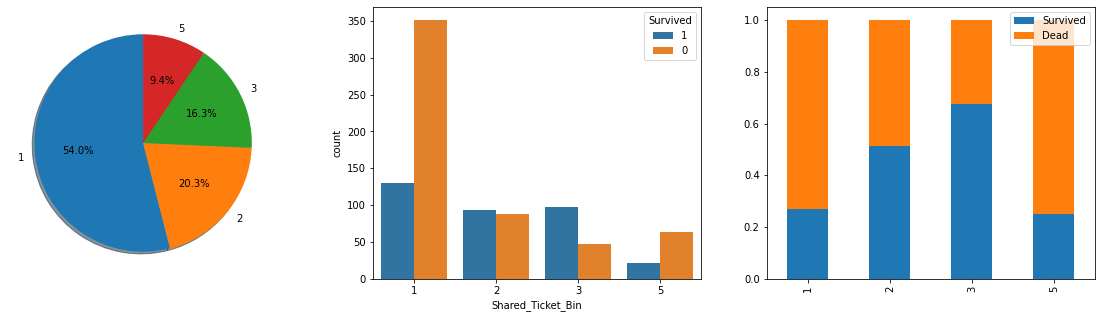

In [22]:
data['Shared_Ticket_Bin'] = data.Shared_Ticket.apply(lambda x: 3 if (x>2 and x<5) else (5 if x>4 else x))
charts('Shared_Ticket_Bin', data[data.Survived>=0])   

### Type Of Ticket
There were different types of tickets that were allocated to the passengers on the titanic. For instance, if the passenger was part of the crew or a VIP their ticket would start with an alphanumeric. Do to the differences in the people that these different tickets were assinged to there may be information in the type of tickets that could prove usefull in predicting the survival of a passenger. 


           ____________________________ Plots of TypeTicket per Survived and Dead: ____________________________


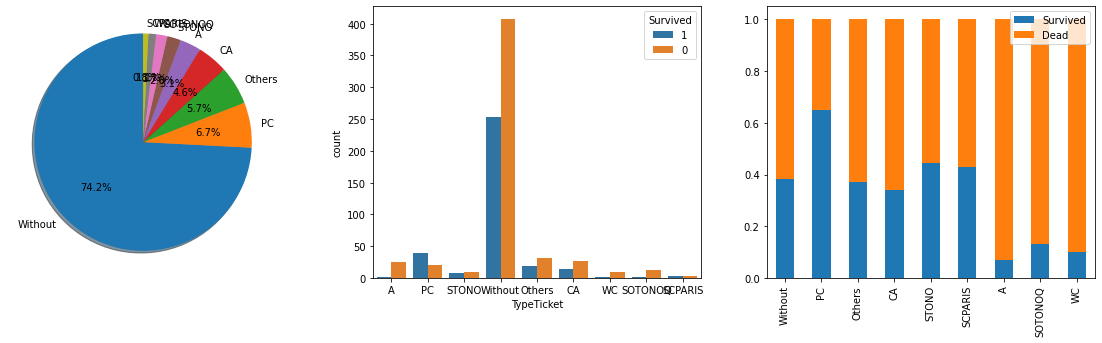

In [23]:
data['TypeTicket'] =(data.Ticket.str.findall('[A-z]').apply(lambda x: ''.join(map(str, x)).strip('[]')))
data.TypeTicket = data.TypeTicket.apply(lambda y: 'Without' if y=='' else y if (y in ['PC', 'CA', 'A', 'SOTONOQ', 'STONO', 'WC', 'SCPARIS']) else 'Others')

charts('TypeTicket', data[(data.Survived>=0)])

### Binning Type of Ticket
Because the sample number for some of the types of tickets is very low, it makes sense to bin similar ticket types together. As shown by the graph below there is a correlation bellow there is a correlation between the type of ticket and the chances of survival. 



           ____________________________ Plots of TypeTicketBin per Survived and Dead: ____________________________


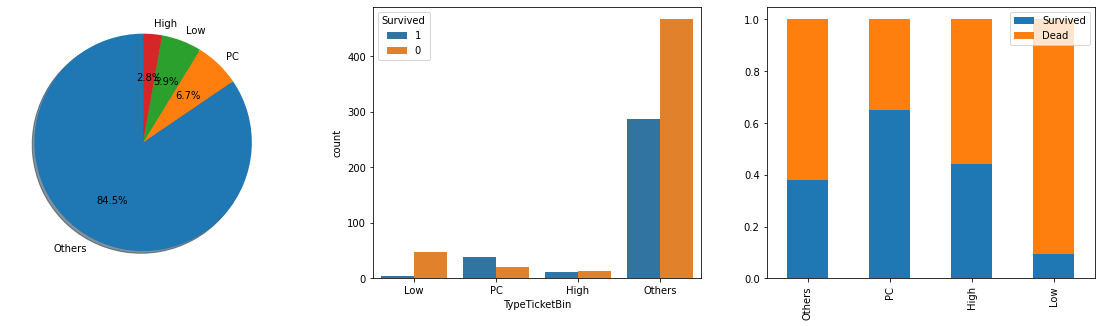

In [24]:
data['TypeTicketBin'] = data.TypeTicket.apply(lambda y: 'Others' if (y in ['Without', 'Others', 'CA']) else\
        'Low' if (y in ['A', 'SOTONOQ', 'WC']) else\
        'High' if (y in ['STONO', 'SCPARIS']) else y)

charts('TypeTicketBin', data[(data.Survived>=0)])

# Fare

As mentioned in the ticket section, when travelling with a group, tickets are shared. For example, when travelling with a group of two the fare will be double that of what is actually paid by an individual passenger in a group. As a result, by using the fare and the number of people per ticket, we can calculate the true fare per passenger. 

In [25]:
# Creating and Looking at the actual passenger fare
data['True_Fare'] = data.Fare / data.Shared_Ticket

# CABINS

Unfortunately, most cabins are null values, however, they may contain important information. For instance, the letter that prefixes the cabin number determines the deck that the passenger was on. The following two diagrams show the deck layout and the water level as the Titanic sunk. 

![Deck](./pictures/titanic2.gif)
![water](./pictures/waterlevel.gif)

As illustrated by the two diagrams there were sides of the ship, where when a passenger would stay there, they had a higher chance of survival. As a result, it may be useful to determine the cabin letter that the passengers stayed in. 



An interesting point is that the cabins in which the passengers stayed were only recorded after the titanic sunk. So only the survivors of the catastrophe could say which cabins they or their deceased partners stayed in. As a result, this information is captured below. 


           ____________________________ Plots of isCabinNull per Survived and Dead: ____________________________


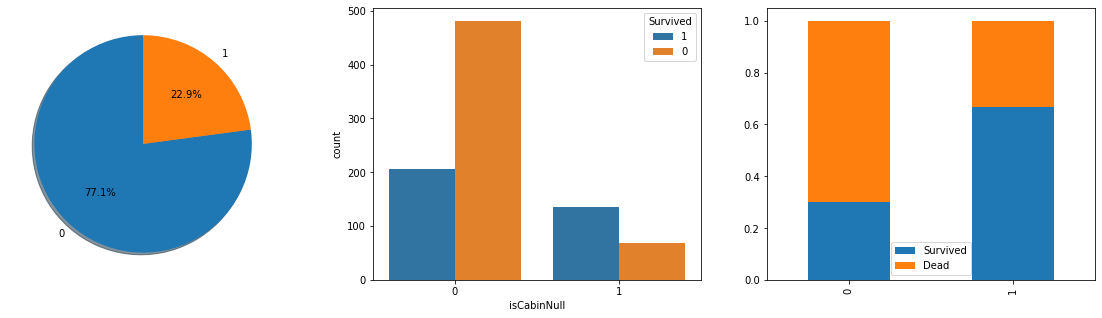

In [26]:
data['isCabinNull'] = None
data['isCabinNull'] = (~data['Cabin'].isnull()).astype(int)
charts('isCabinNull', data[(data.Survived>=0)])

The Graphs above show that when the cabin of the passenger is known there is a 70% chance of surviving as compared to a 30% chance of surviving. 

In [27]:
CabinByTicket = data.loc[~data.Cabin.isnull(), ['Ticket', 'Cabin']].groupby(by='Ticket').agg(min)
data.loc[data.Cabin.isnull(), 'Cabin'] = data.loc[data.Cabin.isnull(), 'Ticket'].\
    apply(lambda x: CabinByTicket[CabinByTicket.index==x].min())
del CabinByTicket, 

In [28]:
# setting all the null cabins to N999
data.Cabin[data.Cabin.isnull()] = 'X'
data['Cabin_Letter'] = data.Cabin.str.findall('[^a-z]\d\d*')
data['Cabin_Number'] = data.apply(lambda x: 0 if len(str(x.Cabin))== 1 else np.int(np.int(x.Cabin_Letter[0][1:])/10), axis=1)
data.Cabin_Letter = data.apply(lambda x: x.Cabin if len(str(x.Cabin))== 1 else x.Cabin_Letter[0][0], axis=1)

In [29]:
data.Cabin_Letter[data.Cabin_Letter=='T'] = 'C'

In [30]:
def FindCabin(bins,cabin_class):
    prev = 0.0
    for i, bin in enumerate(bins):   
        data.loc[(data.True_Fare<bin) & (data.True_Fare>=prev) & (data.Pclass==cabin_class) & (data.Cabin=='X'), 'Cabin_Letter'] =\
            data[(data.True_Fare<bin) & (data.True_Fare>=prev) & (data.Pclass==cabin_class) & (data.Cabin!='X')].Cabin_Letter.mode()[0]
        data.loc[(data.True_Fare<bin) & (data.True_Fare>=prev) & (data.Pclass==cabin_class) & (data.Cabin=='X'), 'Cabin_Number'] =\
            data[(data.True_Fare<bin) & (data.True_Fare>=prev) & (data.Pclass==cabin_class) & (data.Cabin!='X')].Cabin_Number.mode()[0]
        if (i==len(bins)-1):
            data.loc[(data.True_Fare>=bin) & (data.Pclass==cabin_class) & (data.Cabin=='X'), 'Cabin_Letter'] =\
                data[(data.True_Fare>=bin) & (data.Pclass==cabin_class) & (data.Cabin!='X')].Cabin_Letter.mode()[0]
            data.loc[(data.True_Fare>=bin) & (data.Pclass==cabin_class) & (data.Cabin=='X'), 'Cabin_Number'] =\
                data[(data.True_Fare>=bin) & (data.Pclass==cabin_class) & (data.Cabin!='X')].Cabin_Number.mode()[0]

In [31]:
# Finding third class cabins
bins = [6.237,7.225,7.65,7.75,8.0]
FindCabin(bins,3)
# Finding second class cabins
bins = [8.59,10.5,10.501,12.5,13.0,13.1]
FindCabin(bins,2)
#finding first class cabins
bins = [19.69,23.374,25.25,25.929,26.0,26.55,27.5,27.7208,29.7,30.5,30.7,31.684,39.6,41.2,45.51,49.51,70]
FindCabin(bins,1)


           ____________________________ Plots of Cabin_Letter per Survived and Dead: ____________________________


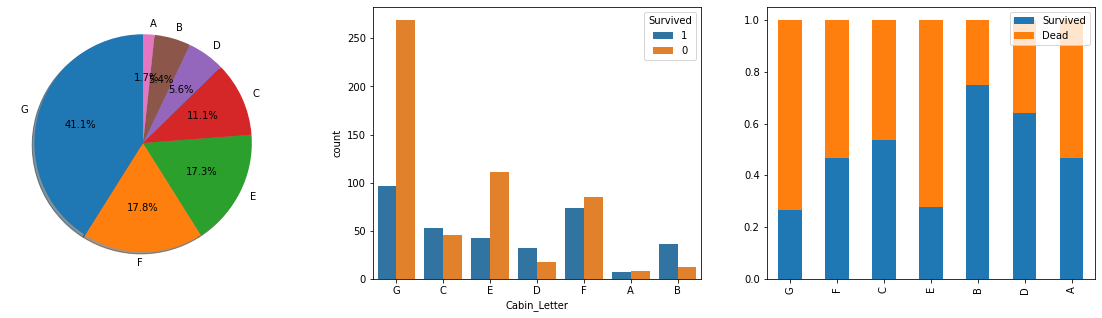

In [32]:
charts('Cabin_Letter', data[(data.Survived>=0)])

The Graphs above show that there is a definite correlation between the cabin where a passenger stayed and the chances of survival. However there are very few people is some cabins and so this may not be an accurate metric due to small sample sizes for some cabins.  

In [33]:
# We can now drop the cabin and ticket
data.drop('Cabin', axis=1,inplace=True)
data.drop('Ticket', axis=1,inplace=True)

# Choice of Machine Learning Model

### Mapping The Data.

In [34]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

# These are the columns that we need to map
columns = ["Sex", "Embarked", "Title", "binned_age","TypeTicketBin","Cabin_Letter", "TypeTicket", "Shared_Ticket_Bin"]
for col in columns:
    data[col] = le.fit_transform(data[col])

### Machine Learning Model Selection

The following machine learning models will be examined in this section, in order to select the best performing model. 
* Logistic Regression
* Decision Tree Classifier
* Random Forest Classifier. 

These three models were chosen due to their variyng approaches at fitting the data. The best parameters for each model was chosen using feature extraction as shown below.

### Automated Feature Selection

To find the best features for each machine learning model, the SelectFromModel library is used from Sklearn. This library determines the best features to be used by ranking all the features based on the importance of each feature. 

i.e. Features with high performance will be kept, and features with low or negative importances will be dropped.
The cross validation of each model is calculated. This value indicates how well the model works for any given train-test split

Suggested Feature Selection For Random Forest Classifier

In [35]:
feat_data = data

In [36]:
feat_data = feat_data.drop(['PassengerId'], axis = 1)

In [37]:
feat_data.head(1)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,isAgeNull,...,Family,hasFamily,Shared_Ticket,Shared_Ticket_Bin,TypeTicket,TypeTicketBin,True_Fare,isCabinNull,Cabin_Letter,Cabin_Number
0,0,3,1,22.0,1,0,7.25,2,2,1,...,1,0,1,0,0,1,7.25,0,6,0


In [38]:
feat_test = feat_data.loc[feat_data.Survived == -1]
feat_test.drop('Survived', axis=1, inplace = True)
feat_train = feat_data.loc[feat_data.Survived != -1]

In [39]:
X = feat_train.drop('Survived', axis = 1)
Y = pd.DataFrame(feat_train.Survived)

In [40]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)

In [41]:
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel

In [42]:
cross_val_score(forest, X, Y, cv = 10).mean()

0.8115480649188515

In [43]:
select_forest = SelectFromModel(estimator=forest)
new_X = select_forest.fit(X,Y) 
selected_feat= X.columns[(select_forest.get_support())]
len(selected_feat)

print(selected_feat)

Index(['Sex', 'Age', 'Fare', 'Title', 'True_Fare'], dtype='object')


Suggested Feature Selection For Logistic Regression

In [44]:
  from sklearn.linear_model import LogisticRegression
  log = LogisticRegression(random_state = 0)
 

In [45]:
cross_val_score(log, X, Y, cv = 10).mean()

0.7856554307116105

In [46]:
select_log = SelectFromModel(estimator=log)
new_X = select_log.fit_transform(X,Y) 
selected_feat= X.columns[(select_log.get_support())]
len(selected_feat)
print(selected_feat)

Index(['Pclass', 'Sex', 'isAgeNull', 'isCabinNull'], dtype='object')


Suggested Feature Selection For Decision Tree Classifier

In [47]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)

In [48]:
cross_val_score(tree, X, Y, cv = 10).mean()

0.8092634207240949

In [49]:
select_tree = SelectFromModel(estimator=tree)
new_X = select_tree.fit(X,Y) 
selected_feat= X.columns[(select_tree.get_support())]
len(selected_feat)
print(selected_feat)

Index(['Pclass', 'Sex', 'Age', 'Fare', 'True_Fare'], dtype='object')


In [50]:
# This sub is tailored to the logistic regression as defined above
sub1 = data[['Survived','Pclass','Sex','isAgeNull', 'isCabinNull']].copy()
# This sub is tailored to the Decision Tree Classifier as defined above
sub2 = data[['Survived','Pclass','Sex','Age','Fare', 'True_Fare']].copy()
# This sub is tailored to the Random forest as defined above
sub3 = data[['Survived', 'Sex', 'Age','Fare', 'Title', 'True_Fare']].copy()

### Model Building


In [51]:
#Create a function within many Machine Learning Models
def models(X_train,Y_train):
  
  #Using Logistic Regression Algorithm to the Training Set
  from sklearn.linear_model import LogisticRegression
  log = LogisticRegression(random_state = 0)
  log.fit(X_train, Y_train)
  
  #Using KNeighborsClassifier Method of neighbors class to use Nearest Neighbor algorithm
  from sklearn.tree import DecisionTreeClassifier
  tree = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
  tree.fit(X_train, Y_train)

  #Using RandomForestClassifier method of ensemble class to use Random Forest Classification algorithm
  from sklearn.ensemble import RandomForestClassifier
  forest = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
  forest.fit(X_train, Y_train)
  
  #print model accuracy on the training data.
  print('[0]Logistic Regression Training Accuracy:', log.score(X_train, Y_train))
  print('[1]Decsion Tree Classifier Training Accuracy:', tree.score(X_train, Y_train))
  print('[2]Random Forest Classifier Training Accuracy:', forest.score(X_train, Y_train))
  
  return log, tree, forest

In [52]:
from sklearn.metrics import confusion_matrix 
def testSet(set):
    test = set.loc[set.Survived == -1]
    test.drop('Survived', axis=1, inplace = True)
    train = set.loc[set.Survived != -1]
    
    num_features = 14
    X = train.iloc[:, 1:num_features].values 
    Y = train.iloc[:, 0].values
    
    # Split the dataset into 80% Training set and 20% Testing set
    from sklearn.model_selection import train_test_split
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)

    #Get and train all of the models
    model = models(X_train,Y_train)

    #Print Confusion Matrices
    for i in range(len(model)):
        cm = confusion_matrix(Y_test, model[i].predict(X_test)) 
        #extracting TN, FP, FN, TP
        TN, FP, FN, TP = confusion_matrix(Y_test, model[i].predict(X_test)).ravel()
        print('Model[{}] Testing Accuracy = "{} !"'.format(i,  (TP + TN) / (TP + TN + FN + FP)))

In [53]:
testSet(sub1)

[0]Logistic Regression Training Accuracy: 0.7865168539325843
[1]Decsion Tree Classifier Training Accuracy: 0.7963483146067416
[2]Random Forest Classifier Training Accuracy: 0.7963483146067416
Model[0] Testing Accuracy = "0.7877094972067039 !"
Model[1] Testing Accuracy = "0.8044692737430168 !"
Model[2] Testing Accuracy = "0.8044692737430168 !"


In [54]:
testSet(sub2)

[0]Logistic Regression Training Accuracy: 0.800561797752809
[1]Decsion Tree Classifier Training Accuracy: 0.9803370786516854
[2]Random Forest Classifier Training Accuracy: 0.9648876404494382
Model[0] Testing Accuracy = "0.7932960893854749 !"
Model[1] Testing Accuracy = "0.8044692737430168 !"
Model[2] Testing Accuracy = "0.8044692737430168 !"


In [55]:
testSet(sub3)

[0]Logistic Regression Training Accuracy: 0.7921348314606742
[1]Decsion Tree Classifier Training Accuracy: 0.9831460674157303
[2]Random Forest Classifier Training Accuracy: 0.9662921348314607
Model[0] Testing Accuracy = "0.776536312849162 !"
Model[1] Testing Accuracy = "0.776536312849162 !"
Model[2] Testing Accuracy = "0.8100558659217877 !"


The results above show us that the random forest is the best performing Machine learning model by taking into account both training and testing accuracies, aswell as the highest cross validation score of the three models. This makes sense as the model is very good at handling large data sets. It can perform both regression and classification tasks. As a result we have chosen to move forward with the Random Forest Classifier.

# ML Tuning

### Parameter Selection

First we will submit our predictions for the random forest classifier to Kaggle using the parameters giving above. 

In [56]:
subKag = data[['Survived', 'Sex', 'Age','Fare', 'Title', 'True_Fare']].copy()

In [57]:
subKag.head()

,Survived,Sex,Age,Fare,Title,True_Fare
0,0,1,22.0,7.2500,2,7.25000
1,1,0,38.0,71.2833,3,35.64165
2,1,0,26.0,7.9250,1,7.92500
3,1,0,35.0,53.1000,3,26.55000
4,0,1,35.0,8.0500,2,8.05000


In [58]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)

test = subKag.loc[subKag.Survived == -1]
test.drop('Survived', axis=1, inplace = True)
train = subKag.loc[subKag.Survived != -1]

num_features = 14
X = train.iloc[:, 1:num_features].values 
Y = train.iloc[:, 0].values

forest.fit(X, Y)

RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=0)

In [59]:
submission_preds = forest.predict(test) 
df = pd.DataFrame({'PassengerId':test_ids.values,
                   'Survived':submission_preds})
df.to_csv('submission1.csv', index=False)
print('Submission Saved!')

Submission Saved!


The figure below shows the result of this submission when uploaded to Kaggle is 0.74880

![sub1](./pictures/sub1.png)

Unfortunately, this is a very low score, as a result, we will need to update the parameters. This is done by using logic and analyzing the importance of each of the parameters.

<AxesSubplot:xlabel='feature'>

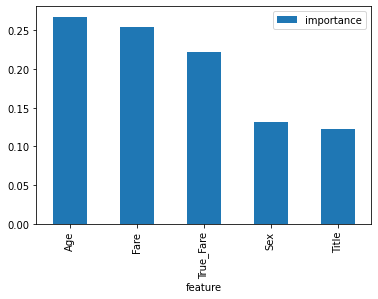

In [60]:
#Get the importance of the features
importances = pd.DataFrame({'feature':train.iloc[:, 1:num_features].columns,'importance':np.round(forest.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.plot.bar()

The graph above shows that the importance of all of the features are nicley distributed, however when analysing the features that are used, some of them do not make complete sense. For instance, Fare should be removed and Age should be replaced by Binned_Age. 

In [61]:
subKag = data[['Survived', 'Sex', 'binned_age', 'Title', 'True_Fare']].copy()

In [62]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)

test = subKag.loc[subKag.Survived == -1]
test.drop('Survived', axis=1, inplace = True)
train = subKag.loc[subKag.Survived != -1]

num_features = 14
X = train.iloc[:, 1:num_features].values 
Y = train.iloc[:, 0].values

forest.fit(X, Y)

RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=0)

In [63]:
submission_preds = forest.predict(test) 
df = pd.DataFrame({'PassengerId':test_ids.values,
                   'Survived':submission_preds})
df.to_csv('submission2.csv', index=False)
print('Submission Saved!')

Submission Saved!


The figure below shows the result of this submission when uploaded to Kaggle is 0.75119 - An improvement. 

![sub1](./pictures/sub2.png)

This score is still very low, we will need to further refine the params. Again this is done by looking at the importances and using logic. 

<AxesSubplot:xlabel='feature'>

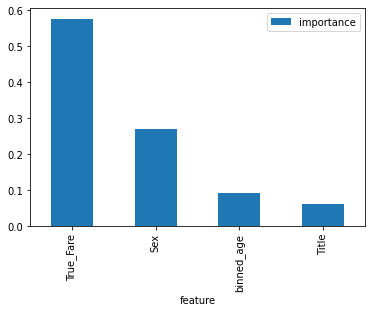

In [64]:
#Get the importance of the features
importances = pd.DataFrame({'feature':train.iloc[:, 1:num_features].columns,'importance':np.round(forest.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.plot.bar()

After Repeating this process many times we find that the best parameters to use are as follows: 
* Title 
* Shared_ticket_bin
* Pclass
* binned_age

These parameters are likely the best because they account for almost all of the data in the smallest number of parameters. For instance, shared_ticket_bin includes information about family members as well as other member's, passengers might be traveling with. Title contains information about the passenger sex and socioeconomic standing and binned age contains more continuous information about the age of the passenger. 

The above demonstrates, that while it is important to understand all the data, it is also important to not fall into the trap of overfitting the model. However, if we started with this mindset we would not have developed and explored parameters like Name and Ticket, which initially come off as useless. Fortunately, we did, and this led us to obtain two of the four parameters that we eventually used in this model.


* Title
* Shared_Ticket_Bin

In [65]:
subKag = data[['Survived','Title', 'Shared_Ticket_Bin', 'Pclass', 'binned_age']].copy()

In [66]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)

test = subKag.loc[subKag.Survived == -1]
test.drop('Survived', axis=1, inplace = True)
train = subKag.loc[subKag.Survived != -1]

num_features = 14
X = train.iloc[:, 1:num_features].values 
Y = train.iloc[:, 0].values

forest.fit(X, Y)

RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=0)

In [67]:
submission_preds = forest.predict(test) 
df = pd.DataFrame({'PassengerId':test_ids.values,
                   'Survived':submission_preds})
df.to_csv('submission3.csv', index=False)
print('Submission Saved!')

Submission Saved!


The figure below shows the result of this submission when uploaded to Kaggle is 0.79904 - A large improvement over previous scores. 

![sub1](./pictures/sub3.png)


# Hyper Params
For the hyperparmeters we will be using a Grid search. 

In [68]:
# X and Y as defined above
# Split the dataset into 80% Training set and 20% Testing set
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)

In [69]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf = RandomForestClassifier(max_features=4, n_estimators=100, random_state = 0)

In [70]:
rf.fit(X_train, Y_train)
rf.score(X_test, Y_test)
Y_pred = rf.predict(X_test)
accuracy_score(Y_pred, Y_test)

0.7821229050279329

In [71]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import numpy as np

max_features_range = np.arange(1,5,1)
n_estimators_range = np.arange(10,180,10)

param_grid = dict(max_features=max_features_range, 
                n_estimators=n_estimators_range)

# Inputting random state here gives better results than when inputting later. 
rf = RandomForestClassifier(random_state = 0)
grid = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)

In [72]:
grid.fit(X_train, Y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_features': array([1, 2, 3, 4]),
                         'n_estimators': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150, 160, 170])})

In [73]:
print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

The best parameters are {'max_features': 2, 'n_estimators': 80} with a score of 0.82


In [74]:
import pandas as pd

grid_results = pd.concat([pd.DataFrame(grid.cv_results_["params"]),pd.DataFrame(grid.cv_results_["mean_test_score"], columns=["Accuracy"])],axis=1)

In [75]:
grid_contour = grid_results.groupby(['max_features','n_estimators']).mean()

In [76]:
grid_reset = grid_contour.reset_index()
grid_reset.columns = ['max_features', 'n_estimators',  'Accuracy']
grid_pivot = grid_reset.pivot('max_features', 'n_estimators')
grid_pivot

Accuracy                                                    \
n_estimators       10        20        30        40        50        60    
max_features                                                               
1             0.816035  0.817414  0.813208  0.814616  0.816015  0.814616   
2             0.816035  0.811809  0.813198  0.814607  0.814607  0.814607   
3             0.817414  0.814607  0.814597  0.816005  0.816005  0.816005   
4             0.811809  0.811790  0.810381  0.811790  0.814587  0.813188   

                                                                          \
n_estimators       70        80        90        100       110       120   
max_features                                                               
1             0.817423  0.814607  0.814607  0.817423  0.816015  0.816015   
2             0.817414  0.818812  0.817414  0.814607  0.814607  0.814607   
3             0.818812  0.818812  0.818812  0.817404  0.817404  0.817404   
4             0.815995  0.815995  0.815995  0.814587  0.814587  0.814587   

                                                                
n_estimators       130       140       150       160       170  
max_features                                                    
1             0.816015  0.816015  0.814607  0.817414  0.811790  
2             0.816005  0.816005  0.816005  0.817404  0.817404  
3             0.817404  0.817404  0.817404  0.817404  0.817404  
4             0.814587  0.814587  0.814587  0.814587  0.814587

In [77]:
x = grid_pivot.columns.levels[1].values
y = grid_pivot.index.values
z = grid_pivot.values

In [78]:
import plotly.graph_objects as go
# X and Y axes labels
layout = go.Layout(
            xaxis=go.layout.XAxis(
              title=go.layout.xaxis.Title(
              text='n_estimators')
             ),
             yaxis=go.layout.YAxis(
              title=go.layout.yaxis.Title(
              text='max_features') 
            ) )

fig = go.Figure(data= [go.Surface(z=z, y=y, x=x)], layout=layout )
fig.update_layout(title='Hyperparameter tuning',
                  scene = dict(
                    xaxis_title='n_estimators',
                    yaxis_title='max_features',
                    zaxis_title='Accuracy'),
                  autosize=False,
                  width=800, height=800,
                  margin=dict(l=65, r=50, b=65, t=90))
fig.show()

Using the information provided above we can set the hyperparameters of the model below. This will be the final model that we use in this notebook. 

In [79]:
#load hyper params into model
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators = 80, max_features = 2,  random_state = 0)        # = 80.143%
best_mod = forest.fit(X, Y)

In [80]:
submission_preds = best_mod.predict(test) 
df = pd.DataFrame({'PassengerId':test_ids.values,
                   'Survived':submission_preds})
df.to_csv('submission_Hyperparms.csv', index=False)
print('Submission Saved!')

Submission Saved!


The figure below shows the final result of the final model. This is a very good score of 0.80143 - one of the highest on the leaderboard.

![sub3](./pictures/subhyp.png)


The figure below shows the standing on the leaderboard. 537 out of 15000 teams.

![sub3](./pictures/leader.png)

Notice that unlike the other models, the estimated accuracy is very close to that of the achieved accuracy. This shows that the model has been fittet very well. 

# Training Error Loss and Validation Loss

### Training Error
Out of the bag error is the way of calculating the error for random forest. It is the average error for each training observation and so this allows Random forest to be fit and validated whilst being trained. 

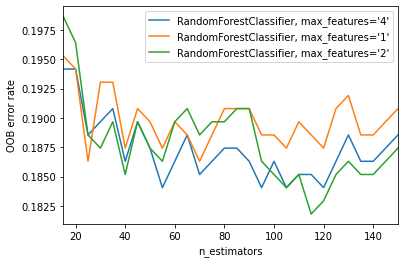

In [81]:
from collections import OrderedDict
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier

ensemble_clfs = [
    (
        "RandomForestClassifier, max_features='4'",
        RandomForestClassifier(
            warm_start=True,
            oob_score=True,
            max_features=4,
            random_state=0,
        ),
    ),
    (
        "RandomForestClassifier, max_features='1'",
        RandomForestClassifier(
            warm_start=True,
            max_features=1,
            oob_score=True,
            random_state=0,
        ),
    ),
    (
        "RandomForestClassifier, max_features='2'",
        RandomForestClassifier(
            warm_start=True,
            max_features=2,
            oob_score=True,
            random_state=0,
        ),
    ),
]


# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 15
max_estimators = 150

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1, 5):
        clf.set_params(n_estimators=i)
        clf.fit(X, Y)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

# Boosting


Below Boosting of the Random forest model was done using the AdaBoostClassifier model. From the average accuracy, it is noted that the boosting does not improve the model. And only changes about 3 values, as seen in the confusion matrix.

In [82]:
print_score(best_mod, X, Y, train=True)

Train Result:

accuracy score: 0.8496

Classification Report: 
               precision    recall  f1-score   support

           0       0.84      0.93      0.88       549
           1       0.86      0.72      0.79       342

    accuracy                           0.85       891
   macro avg       0.85      0.83      0.84       891
weighted avg       0.85      0.85      0.85       891


Confusion Matrix: 
 [[510  39]
 [ 95 247]]

Average Accuracy: 	 0.8081
Accuracy SD: 		 0.0438


In [83]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
ada_clf = AdaBoostClassifier(forest)
boost_mod = ada_clf.fit(X, Y);
print_score(ada_clf, X, Y, train=True)

Train Result:

accuracy score: 0.8496

Classification Report: 
               precision    recall  f1-score   support

           0       0.84      0.94      0.88       549
           1       0.87      0.71      0.78       342

    accuracy                           0.85       891
   macro avg       0.86      0.82      0.83       891
weighted avg       0.85      0.85      0.85       891


Confusion Matrix: 
 [[514  35]
 [ 99 243]]

Average Accuracy: 	 0.8070
Accuracy SD: 		 0.0519


# Cross Validation

The cross validation after the ML tuning of the random forest model decreased. This is strange because the model become more robust when tested by kaggle and looking at the 3D plot. The most important feature used by the model was the title as indicated by the SelectFromModel. 
The cross validation decreased by about 1% but still out preformed the other models

In [84]:
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel

In [85]:
X = train.drop('Survived', axis = 1)
Y = pd.DataFrame(train.Survived)

In [86]:
cross_val_score(forest, X, Y, cv = 10).mean()

0.8081023720349563

In [87]:
select_forest = SelectFromModel(estimator=forest)
new_X = select_forest.fit(X,Y) 
selected_feat= X.columns[(select_forest.get_support())]
len(selected_feat)
print(selected_feat)

Index(['Title'], dtype='object')


The graph above shows that the OOB for max features of two give a lower and more consistant validation error when compared to when the model uses different max features. This reaffirms that the hyperparams chosen for the final model are a good fit. 

# Summary and Conclusion

The final model was a success, it was able to achieve a very good score and placed highly on the Kaggle leader board, 537 out of 15000 – top 4%. This is due to the data analysis which was a success and provided valuable parameters. Furthermore, the parameter selection was a success and encompassed most of the information contained within the data set, this was achieved by training the model on different subsets of data until the best subset was found. Finally, the hyperparameter tuning using a grid search was a success and increased the final score by 1% - this is a significant increase given that the score was already high. 

What did not go well, was the finding suitable methods to compare Machine Learning models, to choose the best one. The only method that was used was comparing the training and testing accuracy. While this method did indicate a model that did perform well, there may have been other models that may have performed better, and more investigation would be needed to identify these models. 

Finally, suitable graphs on Training error and Validation error were not provided adequately. These graphs could’ve been used to find better hyperparameters and better subsets. However, due to time constraints, they could not be fully implemented. 

The code was inspired by many sources and so the nuances in the code change throughout the notebook. More time could have been spent on unifying the code and making it more presentable, especially by following a constant naming convention. 

The automated feature selection gave some insight into which features were useful in terms of individual importance. However, the values of importance did not seem to take into account 'repeated' features in the sense that fetures that contained similar data could sometimes both be included. Sex and title were both included for the one model which is redundant since Title indicates the Sex of a passenger. Fare and True_Fare or Pclass were included togehter yet, these features all indicate the income or wealth of a passenger. Including multiple features with similar data points can cause a model to over fit to satisfy those features. 

The data analysis was performed by both members of the team, with Hraklis Papageorgiou examining the Names, age, and family and Joseph Baggott examining the Ticket, Cabin, and Fare. 
Both team members worked on trial and error in choosing the best machine learning model and both worked on the hyper Param selection. It can be agreed by both group members that this project was a group effort. 


# References
The following References Were Used to Develope The Notebook in This Project:
* https://betterprogramming.pub/titanic-survival-prediction-using-machine-learning-4c5ff1e3fa16?gi=c6ec8eae94cc
* https://github.com/aladdinpersson/Machine-Learning-Collection
* https://github.com/dataprofessor/code/blob/master/python/hyperparameter_tuning.ipynb
* http://vitarts.com.br/titanic-machine-learning-from-disaster-kaggle-copetitions/#Rescue-of-family-relationships
* https://www.kaggle.com/code/skumar2007ctae/titanic-analysis-with-bagging-and-boosting
* https://github.com/ramansah/kaggle-titanic/blob/master/Analysis.ipynb
* https://github.com/knathanieltucker/bit-of-data-science-and-scikit-learn/blob/master/notebooks/FeatureSelection.ipynb